<h2 align=center>Anomaly Detection Using LSTM</h2>

## Task 1: Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
pd.options.mode.chained_assignment = None
import seaborn as sns
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

sns.set(style='whitegrid', palette='muted')
rcParams['figure.figsize'] = 14, 8
np.random.seed(1)
tf.random.set_seed(1)

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.2.0


## Task 2: Load and Inspect Data

In [25]:
df = pd.read_csv('LRO_Data/MainStreet2014.csv', parse_dates=['datetime'])
df = df[['datetime',' cond']]
df.rename(columns={" cond": "cond"})
df.head()

,datetime,cond
0,﻿﻿﻿﻿﻿﻿2014-01-01 00:00:00.000,373.4
1,2014-01-01 00:15:00.000,373.5
2,2014-01-01 00:30:00.000,373.6
3,2014-01-01 00:45:00.000,373.7
4,2014-01-01 01:00:00.000,373.8


In [17]:
df.shape

(35038, 2)

In [22]:
# plotting with plotly to have an interactive chart
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.datetime, y=df.cond, #fig.add_trace adds different types of plots to the same figure.
                    mode='lines',
                    name='cond'))
fig.update_layout(showlegend=True)
fig.show()

AttributeError: 'DataFrame' object has no attribute 'cond'

## Task 3: Data Preprocessing

In [26]:
# create training and testing set. Use 80/20.
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(28030, 2) (7008, 2)


In [8]:
# remove mean and scale to unit vecotrs with standard scalar.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

## Task 4: Create Training and Test Splits

In [9]:
# need to reshape data to "temporalize" into number of samples/timestamps by number of features. We have one feature, we will set samples size to 30 for sequences. We will do this many times, so create a function.
# time steps is the number of rows to consider. Start with 1 and then will change to 30.
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], [] # start empty list
    for i in range(len(X) - time_steps): # loop within range of data frame minus the time steps
        v = X.iloc[i:(i + time_steps)].values # data from i to end of the time step
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys) # convert lists into numpy arrays and return

In [10]:
# create X and y train and test
# set time steps to 30

time_steps = 30

X_train, y_train = create_dataset(train[['close']], train.close, time_steps)
X_test, y_test = create_dataset(test[['close']], test.close, time_steps)

print(X_train.shape)

(6523, 30, 1)


## Task 5: Build an LSTM Autoencoder

In [11]:
# train autoencoder on data with no anomalies. take new point and reconstruct with autoencoder. if resconstruction error is above threshold, then label as anomaly. regression
# set time steps
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

# use sequential model class from keras api - can provide definition as list of layers to the sequential data class.
#input to data - sample is one instance from the dataset (row). number of timesteps by number of features.
# output is the encoded feature vecor of the input data
# can change hyperparams (number cells, dropout rate)

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)), # one LSTM layer
    Dropout(0.2), # dropout regularization
    RepeatVector(timesteps), # replicates the feature vectors from LSTM layer output bector by the number of time steps (e.g., 30 times)
    LSTM(128, return_sequences=True), # mirror the encoder in the reverse fashion to create the decoder
    Dropout(0.2),
    TimeDistributed(Dense(num_features)) # add time distributed layer to get output in correct shape. creates a vector of length = num features output from previous layer. (128) output, creates 128 vector and duplicates the number of features . (in this case, 1)         
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

## Task 6: Train the Autoencoder

In [13]:
# need to fit model to training data
# early stopping to ensure that too many epochs are not used.
# monitor the validation loss for improvements. If network doesn't improve for 3 consecutive epochs, stops training.

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')
history = model.fit(
    X_train, y_train,
    epochs=100, # just set to something high, early stopping iwll monitor.
    batch_size=32, # this can be optimized later
    validation_split=0.1, # use 10% of data for validation, use 90% for training.
    callbacks = [es],# early stopping similar to earlier
    shuffle=False #because order matters
)

Train on 5870 samples, validate on 653 samples
Epoch 1/100
5870/5870 [==============================] - 19s 3ms/sample - loss: 0.1625 - val_loss: 0.1610
Epoch 2/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.1114 - val_loss: 0.0986
Epoch 3/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0903 - val_loss: 0.0443
Epoch 4/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0802 - val_loss: 0.0442
Epoch 5/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0717 - val_loss: 0.0618
Epoch 6/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0774 - val_loss: 0.0326
Epoch 7/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0751 - val_loss: 0.0309
Epoch 8/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0745 - val_loss: 0.0590
Epoch 9/100
5870/5870 [==============================] - 16s 3ms/sample - loss: 0.0759 - val_loss: 0.0528

## Task 7: Plot Metrics and Evaluate the Model

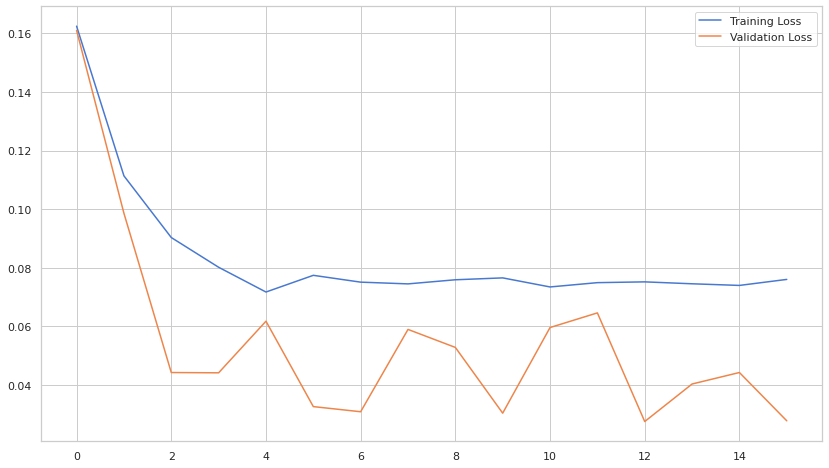

In [14]:
# plot training loss and validation loss with matplotlib and pyplot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

# validation loss consistently lower than training loss. meaning underfit on training data- likely due to high dropout values that we used. could/should modify.

In [15]:
# still need to detect anomalies in our data.
# get model predictions on training data and determine mean absolute error
# loos at the loss for each individual point

X_train_pred = model.predict(X_train)

train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [16]:
# evaluate model on test data
# shows us the total loss of the model

model.evaluate(X_test, y_test)

1609/1609 [==============================] - 2s 972us/sample - loss: 0.2708


0.270815260740746

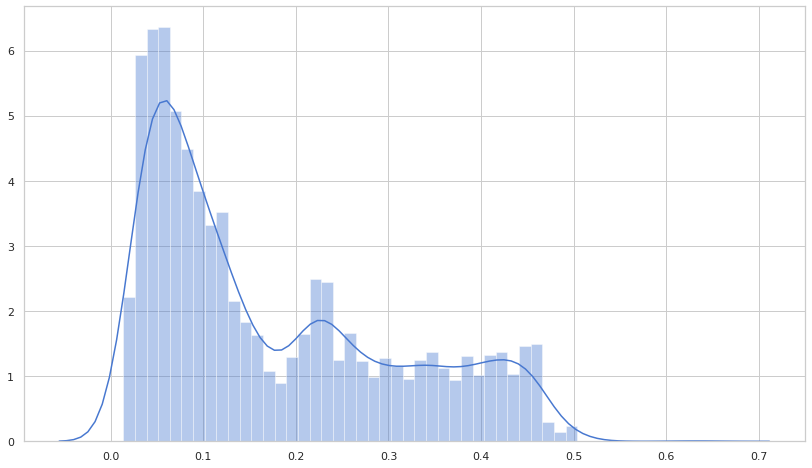

In [17]:
# look at the distribution of the errors using a distribution plot
sns.distplot(train_mae_loss, bins=50, kde=True);

In [18]:
# choose a threshold to use for anomalies based on x-axis. try where error is greater than 0.65, it's anomalous.
threshold = 0.65
X_test_pred = model.predict(X_test)
# calculate mae on test data
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

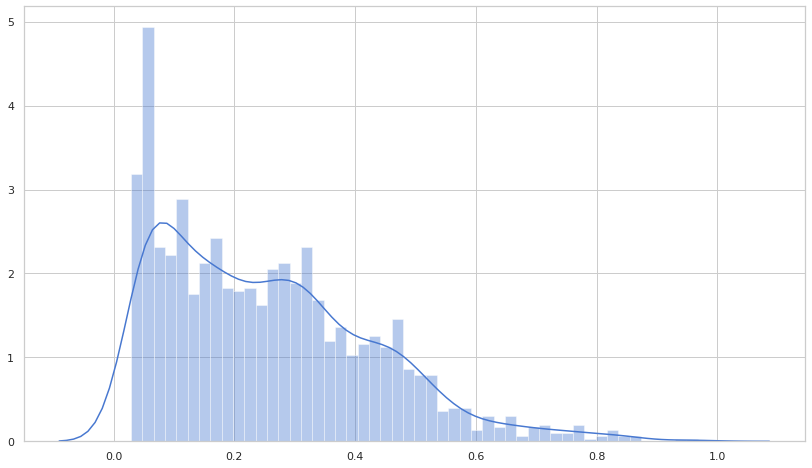

In [19]:
sns.distplot(test_mae_loss, bins=50, kde=True);

## Task 8: Detect Anomalies in the S&P 500 Index Data

In [20]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
# add additional columns for loss value, threshold, whether entry is anomaly or not. could set a variable threshold.
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[time_steps:].close

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.loss,
                    mode='lines',
                    name='Test Loss'))
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=test_score_df.threshold, # add a line to indicate the threshold.
                    mode='lines',
                    name='Threshold'))
fig.update_layout(showlegend=True)
fig.show()

In [22]:
# create data frame for anomalies to explore with more granularity by subsetting
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,date,close,loss,threshold,anomaly
7474,2015-08-25,2.457439,0.655632,0.65,True
7475,2015-08-26,2.632149,0.711593,0.65,True
8090,2018-02-05,4.329949,0.665444,0.65,True
8091,2018-02-06,4.440671,0.853328,0.65,True
8092,2018-02-07,4.408365,0.829433,0.65,True


In [23]:
# look at anomalies in the test data
fig = go.Figure()
fig.add_trace(go.Scatter(x=test[time_steps:].date, y=scaler.inverse_transform(test[time_steps:].close),
                    mode='lines',
                    name='Close Price'))
fig.add_trace(go.Scatter(x=anomalies.date, y=scaler.inverse_transform(anomalies.close),
                    mode='markers',
                    name='Anomaly'))
fig.update_layout(showlegend=True)
fig.show()